# 📈 Predicting User Adoption: Exploratory Analysis

This analysis aims to uncover which user attributes and engagement behaviors most strongly correlate with product adoption. Using two datasets—`takehome_users.csv` and `takehome_user_engagement.csv`—we examine how account creation methods, organization affiliations, and login patterns influence whether a user becomes "adopted."

**Adopted users** are defined as those who logged in on at least **three separate days within a single seven-day window**. By labeling users accordingly and exploring feature relationships, we hope to identify meaningful predictors of user retention and propose strategies for onboarding and engagement improvements.

The notebook walks through:
- Data cleaning and merging
- Adopted-user classification logic
- Exploratory visualizations
- Preliminary modeling to identify influential factors

In [1]:
# 📦 Import libraries
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



## Load databases

In [2]:
# 🧹 Load and clean data
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
engagement = pd.read_csv('takehome_user_engagement.csv')



In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
engagement["user_id"].unique()

array([    1,     2,     3, ..., 11998, 11999, 12000], shape=(8823,))

## Clean and find duplicates or missing values

In [6]:
# 🕒 Convert timestamps
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])



In [7]:
# 🔍 Basic Data Cleaning: Missing & Duplicate Values

# 1️⃣ Check for missing values in users table
print("Missing values in users table:")
print(users.isnull().sum())

# 2️⃣ Check for missing values in engagement table
print("\nMissing values in engagement table:")
print(engagement.isnull().sum())

# 3️⃣ Look for duplicate rows
print("\nDuplicate rows in users:", users.duplicated().sum())
print("Duplicate rows in engagement:", engagement.duplicated().sum())

# 4️⃣ Optional: drop duplicates if found
users = users.drop_duplicates()
engagement = engagement.drop_duplicates()

# 5️⃣ Preview cleaned datasets
print("\nUsers dataset after cleaning:")
display(users.head())

print("\nEngagement dataset after cleaning:")
display(engagement.head())

Missing values in users table:
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

Missing values in engagement table:
time_stamp    0
user_id       0
visited       0
dtype: int64

Duplicate rows in users: 0
Duplicate rows in engagement: 0

Users dataset after cleaning:


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0



Engagement dataset after cleaning:


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


🕒 last_session_creation_time (3,177 missing)
This field tracks the last time a user logged into the product.
- If it's missing, it probably means the user signed up but never logged in.
- These users might have abandoned the product early or created an account passively (like through a Google signup or invite).
  
🧑‍🤝‍🧑 invited_by_user_id (5,583 missing)
This field captures who invited the user, if applicable.
- Missing values here suggest the user either signed up independently (via website or Google Auth)
- Or their invitation info wasn’t tracked (possibly from an external campaign or org-wide email blast).


In [8]:
# 🧠 Label adopted users: logged in ≥3 times in any 7-day window
def is_adopted_user(user_df):
    dates = user_df['time_stamp'].sort_values().reset_index(drop=True)
    for i in range(len(dates) - 2):
        if dates[i+2] - dates[i] <= pd.Timedelta(days=7):
            return True
    return False

adopted_status = engagement.groupby('user_id').apply(is_adopted_user)


adopted_status.head()

C:\Users\albam\AppData\Local\Temp\ipykernel_25624\3689248775.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adopted_status = engagement.groupby('user_id').apply(is_adopted_user)


user_id
1    False
2     True
3    False
4    False
5    False
dtype: bool

In [9]:
adopted_df = adopted_status.reset_index().rename(columns={0: 'is_adopted'})
adopted_df

,user_id,is_adopted
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False
...,...,...
8818,11996,False
8819,11997,False
8820,11998,False
8821,11999,False


In [10]:
users = users.merge(adopted_df, how='left', left_on='object_id', right_on='user_id')
users['is_adopted'] = users['is_adopted'].fillna(False)

C:\Users\albam\AppData\Local\Temp\ipykernel_25624\2996015666.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  users['is_adopted'] = users['is_adopted'].fillna(False)


In [11]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,is_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,3.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,4.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5.0,False


## 📊 Exploratory Analysis

Adoption Rate: 13.8 %


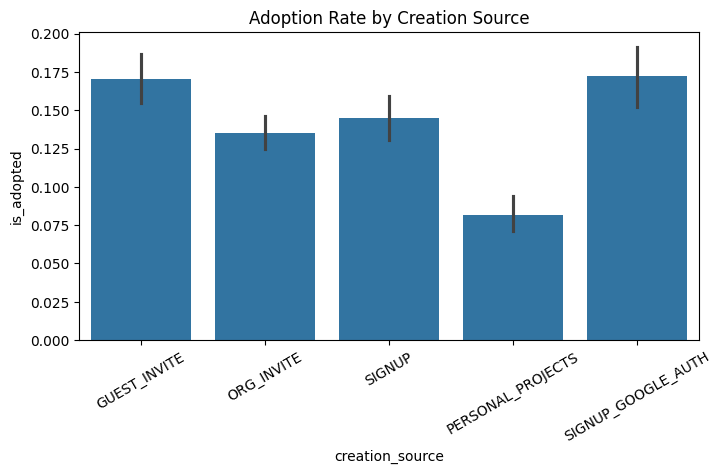

In [12]:
# 📊 Exploratory Analysis
adoption_rates = users['is_adopted'].mean()
print("Adoption Rate:", round(adoption_rates * 100, 2), "%")

# 🔍 Feature impact
plt.figure(figsize=(8,4))
sns.barplot(data=users, x='creation_source', y='is_adopted')
plt.title('Adoption Rate by Creation Source')
plt.xticks(rotation=30)
plt.show()



In [13]:
# Convert timestamps
# Convert creation_time to datetime
users['creation_time'] = pd.to_datetime(users['creation_time'])

# Convert last_session_creation_time (Unix timestamp) to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

# Feature engineering
# Calculate account age in days
users['account_age_days'] = (users['last_session_creation_time'].max() - users['creation_time']).dt.days
users['was_invited'] = users['invited_by_user_id'].notnull().astype(int)
users['email_domain'] = users['email'].str.split('@').str[1]

## Encode categorical variables & Scale

In [ ]:
# Encode categorical variables
encoder = OneHotEncoder(sparse_output=False, drop='first')
creation_source_encoded = encoder.fit_transform(users[['creation_source']])
creation_source_df = pd.DataFrame(creation_source_encoded, columns=encoder.get_feature_names_out(['creation_source']))

# Combine features first
features = pd.concat([users[['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'account_age_days', 'was_invited']],
                      creation_source_df], axis=1)
target = users['is_adopted']

# Scale account_age_days after creating features
scaler = StandardScaler()
features[['account_age_days']] = scaler.fit_transform(features[['account_age_days']])

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

## Logistic Regression

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.57      0.69      3100
        True       0.17      0.56      0.26       500

    accuracy                           0.57      3600
   macro avg       0.53      0.56      0.48      3600
weighted avg       0.79      0.57      0.63      3600


Feature Importance:
                              feature  coefficient
2                    account_age_days     0.260727
7  creation_source_SIGNUP_GOOGLE_AUTH     0.251036
3                         was_invited     0.216028
1          enabled_for_marketing_drip     0.106707
6              creation_source_SIGNUP     0.100482
0            opted_in_to_mailing_list     0.098284
4          creation_source_ORG_INVITE    -0.263972
5   creation_source_PERSONAL_PROJECTS    -0.620588

Confusion Matrix:
[[1758 1342]
 [ 219  281]]

Confusion Matrix Table:
                 Predicted Not Adopted (0)  Predicted Adopted (1)
Not Adopted (0)                  

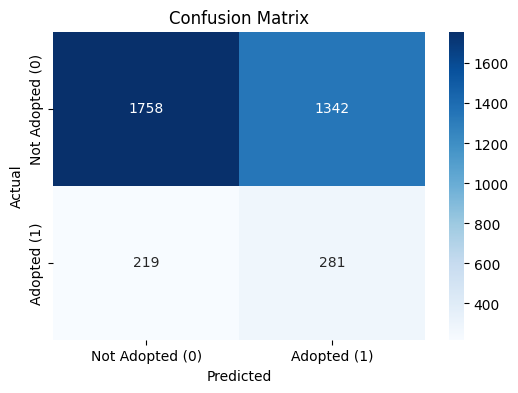

In [15]:
# 🌱 Basic logistic regression



# Logistic regression with balanced weights
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({'feature': features.columns, 'coefficient': model.coef_[0]})
print("\nFeature Importance:")
print(feature_importance.sort_values('coefficient', ascending=False))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Pretty-print confusion matrix as a table
cm_df = pd.DataFrame(cm, 
                     index=['Not Adopted (0)', 'Adopted (1)'], 
                     columns=['Predicted Not Adopted (0)', 'Predicted Adopted (1)'])
print("\nConfusion Matrix Table:")
print(cm_df)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Adopted (0)', 'Adopted (1)'], 
            yticklabels=['Not Adopted (0)', 'Adopted (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Problem: The high number of false positives (FP = 1341) means the model is over-predicting adopted users, leading to low precision (0.17) for the adopted class. This suggests the model is too aggressive in classifying users as adopted, possibly due to the balanced class weights overcompensating for the imbalance.

In [16]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2560  540]
 [ 396  104]]
              precision    recall  f1-score   support

       False       0.87      0.83      0.85      3100
        True       0.16      0.21      0.18       500

    accuracy                           0.74      3600
   macro avg       0.51      0.52      0.51      3600
weighted avg       0.77      0.74      0.75      3600

